In [1]:
import pandas as pd
import vaex
import numpy as np
import io
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold , StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
warnings.filterwarnings("ignore")

INFO:MainThread:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
vtrain = vaex.from_csv('train.csv', convert=True, chunk_size=1_000_000)
vtest = vaex.from_csv('test.csv', convert=True, chunk_size=1_000_000)

In [5]:
type(vtrain)

vaex.dataframe.DataFrameLocal

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
train['source'] = 'train'
test['source'] = 'test'

In [5]:
df = pd.concat([train, test])

In [6]:
df.shape 

(455495, 19)

In [7]:
df.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,source
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10,train
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50,train
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40,train
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50,train
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50,train


In [8]:
df['Stay'] = df['Stay'].replace({'0-10' : 0,
                                     '11-20' : 1,
                                     '21-30': 2,
                                     '31-40': 3,
                                     '41-50': 4,
                                     '51-60': 5,
                                     '61-70': 6, 
                                    '71-80': 7,
                                      '81-90': 8,
                                      '91-100': 9,
                                      'More than 100 Days' : 10
                                     })

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455495 entries, 0 to 137056
Data columns (total 19 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            455495 non-null  int64  
 1   Hospital_code                      455495 non-null  int64  
 2   Hospital_type_code                 455495 non-null  object 
 3   City_Code_Hospital                 455495 non-null  int64  
 4   Hospital_region_code               455495 non-null  object 
 5   Available Extra Rooms in Hospital  455495 non-null  int64  
 6   Department                         455495 non-null  object 
 7   Ward_Type                          455495 non-null  object 
 8   Ward_Facility_Code                 455495 non-null  object 
 9   Bed Grade                          455347 non-null  float64
 10  patientid                          455495 non-null  int64  
 11  City_Code_Patient                  4488

In [10]:
df['Hospital_type_code'].value_counts()

a    204730
b     98884
c     66147
e     35428
d     29048
f     15252
g      6006
Name: Hospital_type_code, dtype: int64

In [11]:
df['Hospital_type_code'] = df['Hospital_type_code'].replace({'a' : 0,
                                     'b' : 1,
                                     'c': 2,
                                     'd': 3,
                                     'e': 4,
                                     'f': 5,
                                     'g': 6
                                     })

In [12]:
df['Hospital_region_code'].value_counts()

X    190849
Y    174707
Z     89939
Name: Hospital_region_code, dtype: int64

In [13]:
df['Hospital_region_code'] = df['Hospital_region_code'].replace({'X' : 0,
                                     'Y' : 1,
                                     'Z': 2})

In [14]:
df['Department'].value_counts()

gynecology            356688
anesthesia             42358
radiotherapy           41033
TB & Chest disease     13751
surgery                 1665
Name: Department, dtype: int64

In [15]:
dept = pd.get_dummies(df['Department'])

In [16]:
df = pd.concat([df, dept], axis = 1)

In [17]:
df.shape

(455495, 24)

In [18]:
df['Ward_Type'].value_counts()

R    182939
Q    152046
S    111166
P      7199
T      2133
U        12
Name: Ward_Type, dtype: int64

In [19]:
df['Ward_Type'] = df['Ward_Type'].replace({'R' : 0,
                                    'Q' : 1,
                                    'S' : 2,
                                    'P' : 3,
                                    'T' : 4,
                                     'U': 5})

In [20]:
del df['Department']

In [21]:
df['Ward_Facility_Code'].value_counts()

F    161470
E     79058
D     74312
C     50279
B     50116
A     40260
Name: Ward_Facility_Code, dtype: int64

In [22]:
df['Bed Grade'].value_counts()

2.0    176451
3.0    158942
4.0     82387
1.0     37567
Name: Bed Grade, dtype: int64

In [23]:
df['Ward_Facility_Code'] = df['Ward_Facility_Code'].replace({'A' : 0,
                                    'B' : 1,
                                    'C' : 2,
                                    'D' : 3,
                                    'E' : 4,
                                     'F': 5})

In [24]:
df['Bed Grade'] = df['Bed Grade'].transform(lambda x: x.fillna('2.0'))

In [25]:
df['Type of Admission'].value_counts()  

Trauma       217672
Emergency    168363
Urgent        69460
Name: Type of Admission, dtype: int64

In [26]:
adtype = pd.get_dummies(df['Type of Admission'])

In [27]:
df = pd.concat([df, adtype], axis = 1)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455495 entries, 0 to 137056
Data columns (total 26 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            455495 non-null  int64  
 1   Hospital_code                      455495 non-null  int64  
 2   Hospital_type_code                 455495 non-null  int64  
 3   City_Code_Hospital                 455495 non-null  int64  
 4   Hospital_region_code               455495 non-null  int64  
 5   Available Extra Rooms in Hospital  455495 non-null  int64  
 6   Ward_Type                          455495 non-null  int64  
 7   Ward_Facility_Code                 455495 non-null  int64  
 8   Bed Grade                          455495 non-null  object 
 9   patientid                          455495 non-null  int64  
 10  City_Code_Patient                  448806 non-null  float64
 11  Type of Admission                  4554

In [29]:
del df['Type of Admission'] 

In [30]:
df['Severity of Illness'].value_counts()

Moderate    251565
Minor       122735
Extreme      81195
Name: Severity of Illness, dtype: int64

In [31]:
sev = pd.get_dummies(df['Severity of Illness'])

In [32]:
df = pd.concat([df, sev], axis = 1)

In [33]:
df.shape

(455495, 28)

In [34]:
del df['Severity of Illness'] 

In [35]:
df['Age'].value_counts()

41-50     91495
31-40     90420
51-60     69506
21-30     58560
71-80     50737
61-70     48619
11-20     23871
81-90     11240
0-10       9140
91-100     1907
Name: Age, dtype: int64

In [36]:
df['Age'] = df['Age'].replace({'0-10' : 0,
                                     '11-20' : 1,
                                     '21-30': 2,
                                     '31-40': 3,
                                     '41-50': 4,
                                     '51-60': 5,
                                     '61-70': 6, 
                                    '71-80': 7,
                                      '81-90': 8,
                                      '91-100': 9,
                                     })

In [37]:
df['City_Code_Patient'] = df.groupby(['Hospital_type_code', 'City_Code_Hospital', 'Hospital_region_code', 'Hospital_code']).City_Code_Patient.transform(lambda x: x.fillna(x.median()))

In [38]:
Train = df[df['source'] == 'train']

In [39]:
Test = df[df['source'] == 'test']

In [40]:
Train.shape

(318438, 27)

In [41]:
Test.shape

(137057, 27)

In [42]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318438 entries, 0 to 318437
Data columns (total 27 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  int64  
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  int64  
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Ward_Type                          318438 non-null  int64  
 7   Ward_Facility_Code                 318438 non-null  int64  
 8   Bed Grade                          318438 non-null  object 
 9   patientid                          318438 non-null  int64  
 10  City_Code_Patient                  318438 non-null  float64
 11  Visitors with Patient              3184

In [43]:
del Train['source']
del Test['source']



In [144]:
yTrain = Train.pop('Stay')

In [205]:
sc = StandardScaler()
ATrain = sc.fit_transform(Train)
ATest = sc.fit_transform(Test)

In [ ]:
sc = StandardScaler()
sTrain = sc.fit_transform(Train)
ATest = sc.fit_transform(Test)

In [75]:
xgb = XGBClassifier(max_depth=6, n_estimators=600)

In [76]:
xgb.fit(sTrain, yTrain)

[17:05:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [77]:
xpred= xgb.predict(sTest)
acc = accuracy_score(yTrain,xgb.predict(sTrain))*100
acc

58.611409442340424

In [78]:
xpred = pd.DataFrame(xpred, columns =['Stay'])

In [79]:
xpred['Stay'] = xpred['Stay'].replace({0.0 : '0-10',
                                     1.0 : '11-20',
                                     2.0 :'21-30',
                                     3.0 :'31-40',
                                     4.0 :'41-50',
                                     5.0 :'51-60',
                                     6.0 :'61-70', 
                                     7.0 :'71-80',
                                     8.0 : '81-90',
                                     9.0 : '91-100',
                                     10.0 : 'More than 100 Days' 
                                     })

In [80]:
sample = pd.read_csv('sample.csv')

In [81]:
sample.head()

,case_id,Stay
0,318439,0-10
1,318440,0-10
2,318441,0-10
3,318442,0-10
4,318443,0-10


In [82]:
sample['Stay'] = xpred

In [83]:
sample.to_csv('out22.csv')

In [68]:
catboost = CatBoostClassifier(eval_metric='Accuracy', max_depth=4, n_estimators=800, verbose=100)
catboost.fit( sTrain, yTrain )   
 
 

Learning rate set to 0.128194
0:	learn: 0.3383484	total: 477ms	remaining: 6m 20s
100:	learn: 0.4120111	total: 28.4s	remaining: 3m 16s
200:	learn: 0.4204775	total: 57.4s	remaining: 2m 51s
300:	learn: 0.4241328	total: 1m 26s	remaining: 2m 23s
400:	learn: 0.4263059	total: 1m 57s	remaining: 1m 56s
500:	learn: 0.4285198	total: 2m 25s	remaining: 1m 26s
600:	learn: 0.4299424	total: 2m 54s	remaining: 57.8s
700:	learn: 0.4315503	total: 3m 19s	remaining: 28.2s
799:	learn: 0.4327310	total: 3m 45s	remaining: 0us


In [69]:
pred = catboost.predict(sTest)

In [70]:
tpred = catboost.predict(sTrain)
print(accuracy_score(yTrain,tpred)*100)
pred1 = pd.DataFrame(pred, columns =['Stay'])

43.27310182829939


In [72]:
tpred = catboost.predict(sTrain)
print(accuracy_score(yTrain,tpred)*100)
pred1 = pd.DataFrame(pred, columns =['Stay'])
pred1['Stay'] = pred1['Stay'].replace({0.0 : '0-10',
                                     1.0 : '11-20',
                                     2.0 :'21-30',
                                     3.0 :'31-40',
                                     4.0 :'41-50',
                                     5.0 :'51-60',
                                     6.0 :'61-70', 
                                     7.0 :'71-80',
                                     8.0 : '81-90',
                                     9.0 : '91-100',
                                     10.0 : 'More than 100 Days' 
                                     })
sample['Stay'] = pred1
sample.to_csv('out21.csv')

43.27310182829939


In [278]:
pred1 = pd.DataFrame(pred, columns =['Stay'])

In [297]:
pred1['Stay'] = pred1['Stay'].replace({0.0 : '0-10',
                                     1.0 : '11-20',
                                     2.0 :'21-30',
                                     3.0 :'31-40',
                                     4.0 :'41-50',
                                     5.0 :'51-60',
                                     6.0 :'61-70', 
                                     7.0 :'71-80',
                                     8.0 : '81-90',
                                     9.0 : '91-100',
                                     10.0 : 'More than 100 Days' 
                                     })

In [298]:
sample['Stay'] = pred1

In [299]:
sample.to_csv('out6.csv')

In [284]:
select_top = SelectKBest(f_classif, k = 10)
x_train_new = select_top.fit_transform(Train, yTrain)
print('Top train features', Train.columns.values[select_top.get_support()])

Top train features ['Available Extra Rooms in Hospital' 'Ward_Type' 'Bed Grade'
 'Visitors with Patient' 'Age' 'Admission_Deposit' 'Emergency' 'Trauma'
 'Extreme' 'Minor']


Index(['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Ward_Type', 'Ward_Facility_Code', 'Bed Grade', 'patientid',
       'City_Code_Patient', 'Visitors with Patient', 'Age',
       'Admission_Deposit', 'TB & Chest disease', 'anesthesia', 'gynecology',
       'radiotherapy', 'surgery', 'Emergency', 'Trauma', 'Urgent', 'Extreme',
       'Minor', 'Moderate'],
      dtype='object')

In [46]:
dTrain = Train
dTest = Test

In [47]:
del dTrain['case_id']
del dTrain['Hospital_code']
del dTrain['City_Code_Hospital']
del dTrain['Hospital_region_code']
del dTrain['patientid']
del dTrain['City_Code_Patient']
del dTest['case_id']
del dTest['Hospital_code']
del dTest['City_Code_Hospital']
del dTest['Hospital_region_code']
del dTest['patientid']
del dTest['City_Code_Patient']

In [48]:
sc = RobustScaler()
sdTrain = sc.fit_transform(dTrain)
sdTest = sc.fit_transform(dTest)

In [294]:
catboost = CatBoostClassifier(eval_metric='Accuracy', max_depth=4, n_estimators=1200, verbose=100)
catboost.fit( sdTrain, yTrain )  

Learning rate set to 0.091006
0:	learn: 0.3590526	total: 445ms	remaining: 8m 53s
100:	learn: 0.4047130	total: 33.9s	remaining: 6m 8s
200:	learn: 0.4098317	total: 1m 4s	remaining: 5m 22s
300:	learn: 0.4129784	total: 1m 35s	remaining: 4m 45s
400:	learn: 0.4147181	total: 2m 6s	remaining: 4m 12s
500:	learn: 0.4163793	total: 2m 37s	remaining: 3m 39s
600:	learn: 0.4175915	total: 3m 9s	remaining: 3m 8s
700:	learn: 0.4187032	total: 3m 40s	remaining: 2m 36s
800:	learn: 0.4193878	total: 4m 11s	remaining: 2m 5s
900:	learn: 0.4204900	total: 4m 43s	remaining: 1m 34s
1000:	learn: 0.4213316	total: 5m 14s	remaining: 1m 2s
1100:	learn: 0.4221010	total: 5m 45s	remaining: 31.1s
1199:	learn: 0.4229018	total: 6m 16s	remaining: 0us


In [295]:
pred = catboost.predict(sdTest)

In [296]:
tpred = catboost.predict(sdTrain)
print(accuracy_score(yTrain,tpred)*100)
pred1 = pd.DataFrame(pred, columns =['Stay'])

42.29017893593101


In [311]:
lg = LGBMClassifier(n_estimators=480,num_leaves=200,max_depth=20)

lg.fit(sTrain,yTrain)
lgp = lg.predict(sTrain)

ac = 100 * accuracy_score(yTrain,lgp)
print('Accuracy Score ', ac)

Accuracy Score  81.65137326575346


In [312]:
pred = lg.predict(sTest)

In [320]:
pred1 = pd.DataFrame(pred, columns =['Stay'])
pred1['Stay'] = pred1['Stay'].replace({0.0 : '0-10',
                                     1.0 : '11-20',
                                     2.0 :'21-30',
                                     3.0 :'31-40',
                                     4.0 :'41-50',
                                     5.0 :'51-60',
                                     6.0 :'61-70', 
                                     7.0 :'71-80',
                                     8.0 : '81-90',
                                     9.0 : '91-100',
                                     10.0 : 'More than 100 Days' 
                                     })
sample['Stay'] = pred1
sample.to_csv('out8.csv')

In [319]:
rf = XGBClassifier(n_estimators=300)

rf.fit(sTrain,yTrain)
rfp = rf.predict(sTrain)

ac = 100 * accuracy_score(yTrain,rfp)
print('Accuracy Score ', ac)

[23:13:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score  53.327178289023294


In [321]:
pred = rf.predict(sTest)

In [322]:
pred1 = pd.DataFrame(pred, columns =['Stay'])
pred1['Stay'] = pred1['Stay'].replace({0.0 : '0-10',
                                     1.0 : '11-20',
                                     2.0 :'21-30',
                                     3.0 :'31-40',
                                     4.0 :'41-50',
                                     5.0 :'51-60',
                                     6.0 :'61-70', 
                                     7.0 :'71-80',
                                     8.0 : '81-90',
                                     9.0 : '91-100',
                                     10.0 : 'More than 100 Days' 
                                     })
sample['Stay'] = pred1
sample.to_csv('out9.csv')

In [329]:
rf = LogisticRegression(max_iter=500) 

rf.fit(sTrain,yTrain)
rfp = rf.predict(sTrain)

ac = 100 * accuracy_score(yTrain,rfp)
print('Accuracy Score ', ac)

Accuracy Score  36.992758401949516


In [328]:
rf = LogisticRegression(max_iter=500) 

rf.fit(sdTrain,yTrain)
rfp = rf.predict(sdTrain)

ac = 100 * accuracy_score(yTrain,rfp)
print('Accuracy Score ', ac)

Accuracy Score  36.651718701913715


In [330]:
pred = rf.predict(sTest)
pred1 = pd.DataFrame(pred, columns =['Stay'])
pred1['Stay'] = pred1['Stay'].replace({0.0 : '0-10',
                                     1.0 : '11-20',
                                     2.0 :'21-30',
                                     3.0 :'31-40',
                                     4.0 :'41-50',
                                     5.0 :'51-60',
                                     6.0 :'61-70', 
                                     7.0 :'71-80',
                                     8.0 : '81-90',
                                     9.0 : '91-100',
                                     10.0 : 'More than 100 Days' 
                                     })
sample['Stay'] = pred1
sample.to_csv('out10.csv')

In [334]:
rf = DecisionTreeClassifier() 

rf.fit(sTrain,yTrain)
rfp = rf.predict(sTrain)

ac = 100 * accuracy_score(yTrain,rfp)
print('Accuracy Score ', ac)

Accuracy Score  100.0


In [335]:
pred = rf.predict(sTest)
pred1 = pd.DataFrame(pred, columns =['Stay'])
pred1['Stay'] = pred1['Stay'].replace({0.0 : '0-10',
                                     1.0 : '11-20',
                                     2.0 :'21-30',
                                     3.0 :'31-40',
                                     4.0 :'41-50',
                                     5.0 :'51-60',
                                     6.0 :'61-70', 
                                     7.0 :'71-80',
                                     8.0 : '81-90',
                                     9.0 : '91-100',
                                     10.0 : 'More than 100 Days' 
                                     })
sample['Stay'] = pred1
sample.to_csv('out12.csv')

In [ ]:
svm = SVC(kernel='rbf', C=1, gamma='auto')
svm.fit(sTrain, yTrain)
svc = svm.predict(sTrain)

sac = 100 * accuracy_score(yTrain,svc)
print('Accuracy Score ', sac)

In [44]:
from autoviml.Auto_ViML import Auto_ViML
target = 'Stay'

Imported Auto_ViML version: 0.1.682. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            verbose=1)
            

Imported Auto_NLP version: 0.0.46.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


##############  D A T A   S E T  A N A L Y S I S  #######################
ALERT! Changing hyperparameter search to RS. Otherwise XGBoost will take too long for 10,000+ rows.
Training Set Shape = (318438, 19)
    Training Set Memory Usage = 46.16 MB
Test Set Shape = (137057, 18)
    Test Set Memory Usage = 18.82 MB
Single_Label Target: ['Stay']

################ Multi_Classification VISUALIZATION Started #####################
Random shuffling the data set before training
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
ALERT! Setting Imbalanced_Flag to True in Auto_ViML for Multi_Classification problems improves results!
       Class  -> Counts -> Percent
        0-10:   23604  ->    7.4%
       11-20:   78139  ->   24.5%
       21-30:   87491  ->   27.5%
       31-40:   55159  ->   17.3%
       41-50:   11743  ->    3.7%
       51-60:   35018  ->   11.0%
       61-70:    2744  ->    0.9%
       71-80:   10254  ->    3.2%
       81-90:    4

[10:14:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
    Resampled data Training time taken = 420 seconds
########################################################
Resampled model results on Held out Validation data:
              precision    recall  f1-score   support

           0       0.46      0.71      0.56     69993
           1       0.48      0.57      0.52     62511
           2       0.52      0.30      0.38     44127
           3       0.51      0.58      0.54     28014
           4       0.64      0.15      0.25     18883
           5       0.96      0.05      0.09      9394
           6       0.87      0.19      0.31      8203
           7       0.83      0.63      0.71      5347
           8       0.82      0.56      0

[10:27:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:28:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:28:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:42:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:44:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

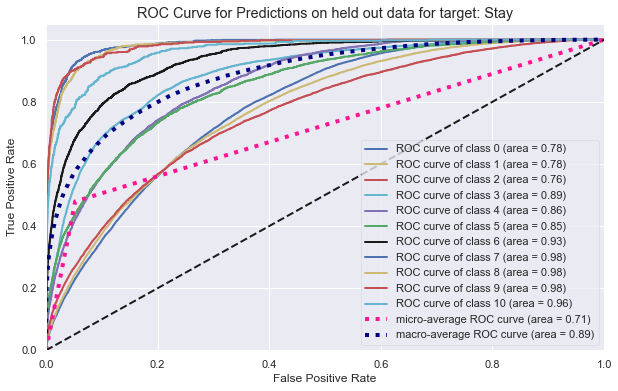

Average precision score, micro-averaged over all classes: 0.50
Macro F1 score, averaged over all classes: 0.37


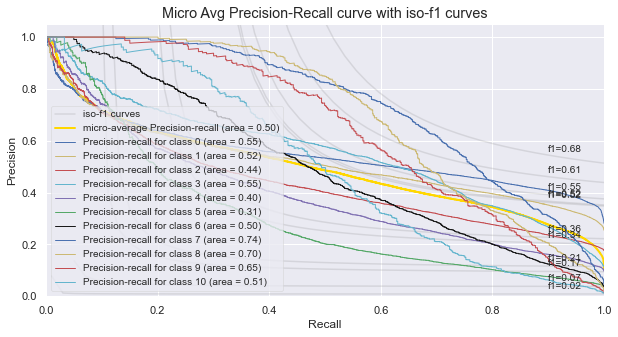

Could not plot Model Evaluation Results Metrics
    Time taken for this Target (in seconds) = 3794
Determining which of 1 continuous variables should be Entropy Binned...
    Selected and binned only top 1 continuous variables.
    ['Bed Grade_bin']
CAUTION: Stacking can produce Highly Overfit models on Training Data...
    Time taken for Stacking: 5.9 seconds
    Adding 2 Stacking feature(s) to training data
    Time taken for Stacking: 1.2 seconds
Performing MinMax scaling of train and test data...
#####   T R A I N I N G   M O D E L   O N    F U L L   T R A I N  D A T A  #############
##################  Imbalanced Model Training  ############################
Imbalanced Training using SMOTE Rare Class Oversampling method...
Using SMOTE's over-sampling techniques to make the 11 classes balanced...
    class_weights = [0.03308787 0.03704796 0.05248266 0.08266865 0.12264408 0.24652056
 0.28231821 0.43317236 0.59836521 1.04697682 1.0549894 ]
    class_weighted_rows = {0: 87491, 1: 78139

[11:01:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:01:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:02:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:03:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[11:16:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:17:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:17:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[11:31:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:33:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[11:47:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:47:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:48:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

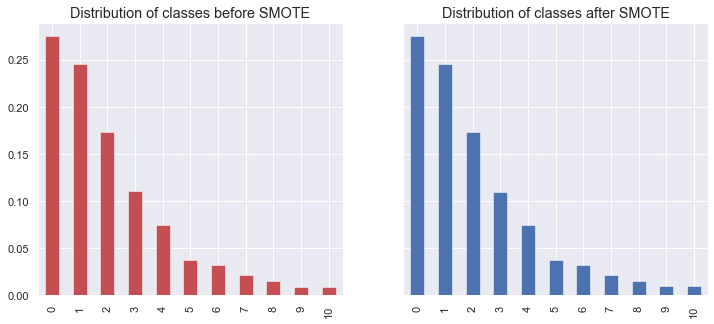

In [45]:
model, features, trainm, testm = Auto_ViML(train, target, test, sample_submission='',
                                           scoring_parameter = 'balanced_Accuracy',
                                          hyper_param = 'RS',
                                          feature_reduction=True,
                                          Boosting_Flag= True,
                                          Binning_Flag=True,
                                          Add_Poly=0,
                                          Stacking_Flag=True,
                                          Imbalanced_Flag=True,
                                          verbose=1)

In [46]:
model

CalibratedClassifierCV(base_estimator=OneVsRestClassifier(estimator=XGBClassifier(base_score=None,
                                                                                  booster='gbtree',
                                                                                  colsample_bylevel=None,
                                                                                  colsample_bynode=None,
                                                                                  colsample_bytree=None,
                                                                                  gamma=None,
                                                                                  gpu_id=None,
                                                                                  importance_type='gain',
                                                                                  interaction_constraints=None,
                                                                              

In [47]:
features

['Visitors with Patient',
 'Ward_Type',
 'Type of Admission',
 'Available Extra Rooms in Hospital',
 'Severity of Illness',
 'Hospital_type_code',
 'Hospital_region_code',
 'City_Code_Hospital',
 'Ward_Facility_Code',
 'Hospital_code',
 'Department',
 'Age',
 'patientid',
 'City_Code_Patient_Missing_Flag',
 'Bed Grade_Missing_Flag',
 'Bed Grade_bin',
 'Linear Discriminant_0',
 'Linear Discriminant_1']

In [48]:
testm.head()

,case_id,Visitors with Patient,Ward_Type,Type of Admission,Available Extra Rooms in Hospital,Severity of Illness,Hospital_type_code,Hospital_region_code,City_Code_Hospital,Ward_Facility_Code,Hospital_code,Department,Age,patientid,City_Code_Patient_Missing_Flag,Bed Grade_Missing_Flag,Bed Grade_bin,Linear Discriminant_0,Linear Discriminant_1,Stay_proba_21-30,Stay_proba_11-20,Stay_proba_31-40,Stay_proba_51-60,Stay_proba_0-10,Stay_proba_41-50,Stay_proba_71-80,Stay_proba_More than 100 Days,Stay_proba_81-90,Stay_proba_91-100,Stay_proba_61-70,Stay_predictions,Stay_Stacked_Linear Discriminant_predictions
0,318439,0.06,0.60,0.00,0.12,1.00,0.33,1.00,0.17,0.00,0.65,0.50,0.78,0.13,0.00,0.00,0.33,0.98,0.02,0.33,0.26,0.13,0.06,0.14,0.04,0.01,0.01,0.01,0.01,0.01,21-30,21-30
1,318440,0.12,0.60,0.50,0.08,1.00,0.00,0.00,0.25,1.00,0.90,0.50,0.78,0.13,0.00,0.00,0.33,0.98,0.02,0.01,0.04,0.16,0.49,0.00,0.02,0.17,0.02,0.00,0.07,0.01,51-60,21-30
2,318441,0.09,0.20,0.00,0.12,1.00,0.17,0.50,0.08,0.60,0.81,0.50,0.78,0.13,0.00,0.00,1.00,0.98,0.02,0.34,0.21,0.13,0.04,0.15,0.08,0.01,0.01,0.02,0.00,0.02,21-30,21-30
3,318442,0.09,0.20,0.50,0.12,1.00,0.00,0.00,0.42,1.00,0.16,0.50,0.78,0.13,0.00,0.00,0.33,0.99,0.01,0.52,0.19,0.16,0.04,0.03,0.05,0.00,0.00,0.00,0.00,0.01,21-30,21-30
4,318443,0.12,0.40,0.50,0.08,1.00,0.17,0.00,0.83,1.00,0.87,0.50,0.78,0.13,0.00,0.00,0.33,0.98,0.02,0.02,0.05,0.16,0.55,0.00,0.02,0.15,0.02,0.00,0.03,0.01,51-60,21-30


In [49]:
trainm.head()

,Visitors with Patient,Ward_Type,Type of Admission,Available Extra Rooms in Hospital,Severity of Illness,Hospital_type_code,Hospital_region_code,City_Code_Hospital,Ward_Facility_Code,Hospital_code,Department,Age,patientid,City_Code_Patient_Missing_Flag,Bed Grade_Missing_Flag,Stay,Bed Grade_bin,Linear Discriminant_0,Linear Discriminant_1
0,2,2,0,3,0,2,2,3,5,8,3,5,31397,0,0,4,1,0.99,0.01
1,2,3,1,2,0,2,2,5,5,2,3,5,31397,0,0,5,1,0.99,0.01
2,2,3,1,2,0,4,0,1,4,10,1,5,31397,0,0,2,1,0.99,0.01
3,2,2,1,2,0,1,1,2,3,26,3,5,31397,0,0,5,1,0.99,0.01
4,2,3,1,2,0,1,1,2,3,26,3,5,31397,0,0,5,1,0.99,0.01
